In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from igraph import *
import networkx as nx
from random import uniform, seed
import numpy as np
import pandas as pd
import time

In [5]:
def IC(graph_object,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
                       
            # 1. Find out-neighbors for each newly active node
            if isinstance(graph_object, Graph):
                targets = propagate_ig(graph_object,p,new_active)
            elif isinstance(graph_object, nx.DiGraph):
                targets = propagate_nx(graph_object,p,new_active)
            elif isinstance(graph_object, dict):
                targets = propagate_dict(graph_object,p,new_active)
            elif isinstance(graph_object, pd.DataFrame):
                targets = propagate_df(graph_object,p,new_active)
    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread),A)

In [6]:
def propagate_nx(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)

In [7]:
def propagate_ig(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node,mode="out")
        
    return(targets)

In [8]:
def propagate_dict(g,p,new_active):
    
    targets = []
    for node in new_active:       
        targets += g.get(node,[])
    
    return(targets)

In [9]:
def propagate_df(g,p,new_active):
    
    # Restrict dataset to edges that flow out of newly active nodes
    temp = g.loc[g['source'].isin(new_active)]

    # Extract target nodes
    targets = temp['target'].tolist()
    
    return(targets)

In [12]:
# Define graph creation function
def make_graph(nodes,edges):
    
    # Generate igraph object
    G = Graph.Erdos_Renyi(n=nodes,m=edges,directed=True)

    # Transform into NetworkX object
    g = nx.DiGraph(G.get_edgelist())

    # Transform into dictionary
    source_nodes = [edge.source for edge in G.es]
    target_nodes = [edge.target for edge in G.es]
    d = {}
    for s, t in zip(source_nodes,target_nodes):
        d[s] = d.get(s,[]) + [t]
        
    # Transform into dataframe
    df = pd.DataFrame({'source': source_nodes,'target': target_nodes})

    return(G, g, d, df)

# Create Graphs
G, g, d, df = make_graph(1000,3000)

In [13]:
# Choose arbitrary seed set
S = [0,20,33,4]

# Run algorithms
output_ig, A_ig = IC(G,S,p=0.2,mc=100)
output_nx, A_nx = IC(g,S,p=0.2,mc=100)
output_di, A_di = IC(d,S,p=0.2,mc=100)
output_df, A_df = IC(df,S,p=0.2,mc=100)

# Print size of cascade
print("Size of cascade:")
print(output_ig,output_nx,output_di,output_df)

# Print last activated set of nodes
print("\nLast Resulting Cascade:")
print(A_ig); print(A_nx); print(A_di); print(A_df)

Size of cascade:
29.9 29.9 29.9 29.9

Last Resulting Cascade:
[0, 20, 33, 4, 794, 517, 882, 324]
[0, 20, 33, 4, 794, 517, 882, 324]
[0, 20, 33, 4, 794, 517, 882, 324]
[0, 20, 33, 4, 794, 517, 882, 324]


In [16]:
# Simulate the processes for different network sizes
e_size = [5000,10000,50000,100000,500000]
ig_time, nx_time, df_time, di_time = [], [], [], []

for edges in e_size:
    
    G, g, d, df = make_graph(5000,edges)
    
    start_time = time.time() 
    _ = IC(G,S,p=0.2,mc=100)
    ig_time.append(time.time() - start_time)

    start_time = time.time() 
    _ = IC(g,S,p=0.2,mc=100)
    nx_time.append(time.time() - start_time)

    start_time = time.time() 
    _ = IC(d,S,p=0.2,mc=100)
    di_time.append(time.time() - start_time)
    
    start_time = time.time() 
    _ = IC(df,S,p=0.2,mc=100)
    df_time.append(time.time() - start_time)

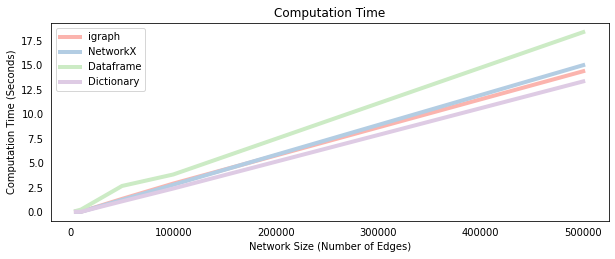

In [17]:
# Plot all methods
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.plot(e_size, ig_time, label="igraph", color="#FBB4AE",lw=4)
ax.plot(e_size, nx_time, label="NetworkX",color="#B3CDE3",lw=4)
ax.plot(e_size, df_time, label="Dataframe",color="#CCEBC5",lw=4)
ax.plot(e_size, di_time, label="Dictionary",color="#DECBE4",lw=4)
ax.legend(loc = 2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Network Size (Number of Edges)')
plt.title('Computation Time')
plt.tick_params(bottom = False, left = False)
plt.show()